The goal here is to evaluate the errors introduced adversarial training by a analyzing the added noise

In [44]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

In [45]:
origWeights = np.load('origWeights.npy', allow_pickle=True)
modifiedWeights = np.load('modifiedWeights.npy', allow_pickle=True)
origBiases = np.load('origBiases.npy', allow_pickle=True)
modifiedBiases = np.load('modifiedBiases.npy', allow_pickle=True)

In [46]:
def compute_minAndMax(listArrays):
    '''
    Function to find the smallest and largest elements 
    in a list of numpy arrays
    '''
    minVal = np.inf
    maxVal = -np.inf
    for arr in listArrays:
        if arr.min() < minVal:
            minVal = arr.min()
        if arr.max() > maxVal:
            maxVal = arr.max()
    return minVal, maxVal

In [47]:
def measure_noise(origValues, modifiedValues):
    noiseValues = []
    for origArr, modifiedArr in zip(origValues, modifiedValues):
        # error_arr is the element-wise difference of all values in the array
        errorArr = origArr - modifiedArr
        noiseValues.append(errorArr)
    return noiseValues

In [48]:
def compute_Tsne(noise):
    """ Computes the t-SNE embedding corresponding to noise. noise is expected to be an nd-array representing 
    the noise values in the convolutional filters of the CNN. The function converts the kernels in the convolutional
    layers into 9*1 vectors and embeds them into a 2D space using t-SNE """
    noiseVectors = []
    for layer in noise:
        # Each conv layer contains a kernel of 3*3 dimensions and varying depth.
        for kernel in layer.T:
            # Each kernel can be split up into 3*3 matrices.
            for matrix in kernel:
                # The matrices are flattened into 9*1 vectors and appended to the list.
                noiseVectors.append(matrix.flatten())
    noiseTsne = TSNE(n_components=2, perplexity=100, n_iter=1200).fit_transform(noiseVectors)
    return noiseTsne

In [49]:
# The CNN for MNIST and the CNN for CIFAR-10, both have convolutional layers followed by a dense layer and then
# a softmax layer. So, the number of conv layers is 2 less than the total number of layers.
numConvLayers = len(origWeights) - 2
modelNoise = measure_noise(origWeights, modifiedWeights)
modelNoiseConvLayers = modelNoise[:numConvLayers]

In [50]:
for layer in modelNoiseConvLayers:
    print(layer.T.shape)
colors = []
if numConvLayers == 3:
    palette = ['r', 'g', 'b']
else:
    palette = ['r', 'g', 'b', 'y', 'c']

# Create a array of colors representing the layers to which the various 9*1 vectors belong to.
for layer,c in zip(modelNoiseConvLayers, palette):
    for kernel in layer.T:
        for matrix in kernel:
            colors.append(c)

(32, 3, 3, 3)
(32, 32, 3, 3)
(64, 32, 3, 3)
(64, 64, 3, 3)
(128, 64, 3, 3)


In [51]:
modelNoiseTsne = compute_Tsne(modelNoiseConvLayers)

Text(0.5, 1.0, 'Model Noise')

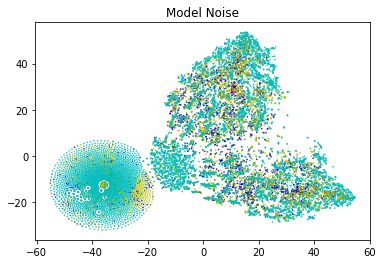

In [52]:
modelNoise_x, modelNoise_y = modelNoiseTsne.T
plt.scatter(modelNoise_x, modelNoise_y, s=0.3, c=colors)
plt.title('Model Noise')

Text(0.5, 1.0, 'Oval pattern')

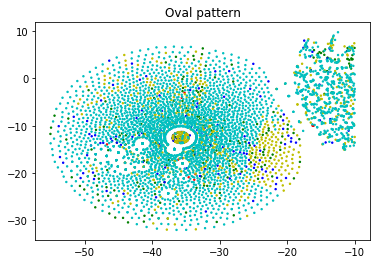

In [60]:
# Code to isolate the circular pattern from the plot
# Using 4 threshold values, I isolate a rectangular 
# region of the plot which contains the oval pattern
x_range = (-60,-10)
y_range = (-40,10)
indices = (modelNoise_x < x_range[1]) * (modelNoise_y < y_range[1]) * \
(modelNoise_x > x_range[0]) * (modelNoise_y > y_range[0])

# Plot the isolated pattern to verify that circular pattern 
# was correctly isolated
colors = np.array(colors)
plt.scatter(modelNoise_x[indices], modelNoise_y[indices], c = colors[indices], s=2)
#for idx in nonZeroPatternIndices:
#    plt.plot(modelNoise_x[idx], modelNoise_y[idx], 'mo', markersize=4)
plt.title('Oval pattern')

In [58]:
noiseVectors = []
for layer in modelNoiseConvLayers:
    for kernel in layer.T:
        for matrix in kernel:
            noiseVectors.append(matrix.flatten())
patternIndices = np.nonzero(indices)[0]
nonZeroPatternIndices =[]
for idx in np.nditer(patternIndices):
    if (noiseVectors[idx] != 0).any():
        nonZeroPatternIndices.append(idx)

In [61]:
def generate_GaussianNoise(noise):
    """ Generate Gaussian noise with the same shape and range as noise. The mean of the generated noise is always 
    0, and the standard deviation is chosen as range/6. This is based on the fact that 99.7% of the values in 
    a Gaussian distribution are within a 6*sigma width around the mean. This makes the range of the generated 
    Gaussian noise approximates same as the range of noise."""
    randNoise = []
    minNoise, maxNoise = compute_minAndMax(noise)
    sigma = (maxNoise - minNoise)/6
    for layer in noise:
        randLayer = np.random.normal(0, sigma, layer.shape)
        randNoise.append(randLayer)
    return randNoise

In [62]:
# Generate the Gaussian noise and compute its t-SNE embedding.
randNoise = generate_GaussianNoise(modelNoise)
randNoiseConvLayers = randNoise[:numConvLayers]
randNoiseTsne = compute_Tsne(randNoiseConvLayers)

In [63]:
def flatten_listArrays(listArrays):
    flattenedArray = np.array([])
    for array in listArrays:
        flattenedArray = np.append(flattenedArray, array.flatten())
    return flattenedArray

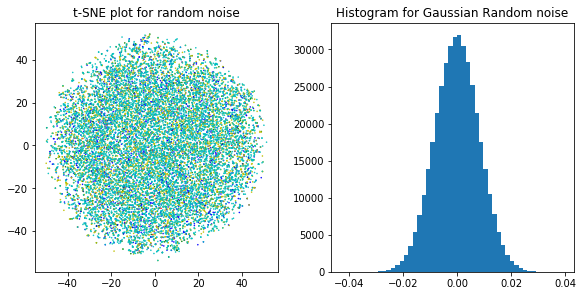

In [64]:
f, axarr = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
randNoise_x, randNoise_y = randNoiseTsne.T
axarr[0].scatter(randNoise_x, randNoise_y, s=0.3, c=colors)
axarr[0].set(title ='t-SNE plot for random noise')
# The random noise must be flattened before plotting the histogram.
randNoise1D = flatten_listArrays(randNoise)
axarr[1].hist(randNoise1D, 50)
axarr[1].set(title = 'Histogram for Gaussian Random noise')
plt.show()

In [65]:
# Compute random noise for all of the layers in the same shape as the neural network weights.
def compute_realNoise(modelNoise, randNoise, k = 0.01):
    """ Generates real noise consisting of model noise with varying amounts of random noise. The generated noise 
    has the same shape as the input model noise. Both modelNoise and randNoise are expected to have the same 
    length """
    realNoise = []
    for modelLayer, randLayer in zip(modelNoise, randNoise):
        realLayer = modelLayer + k*randLayer
        realNoise.append(realLayer)
    return realNoise

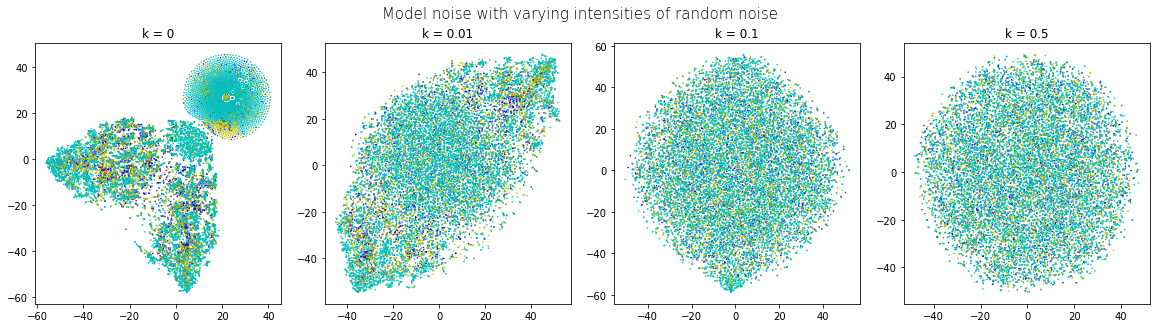

In [66]:
noiseCoefs = [0, 0.01, 0.1, 0.5]
numplots = len(noiseCoefs)
f, axarr = plt.subplots(1, numplots, figsize=(16,4.5), constrained_layout=True)
f.suptitle('Model noise with varying intensities of random noise', fontsize=15, fontweight=15)
for pltIdx, k in enumerate(noiseCoefs):
    realNoise = compute_realNoise(modelNoiseConvLayers, randNoiseConvLayers, k)
    realNoiseTsne = compute_Tsne(realNoise)
    realNoise_x, realNoise_y = realNoiseTsne.T
    axarr[pltIdx].scatter(realNoise_x, realNoise_y, s=0.3, c=colors)
    axarr[pltIdx].set(title='k = {}'.format(k))

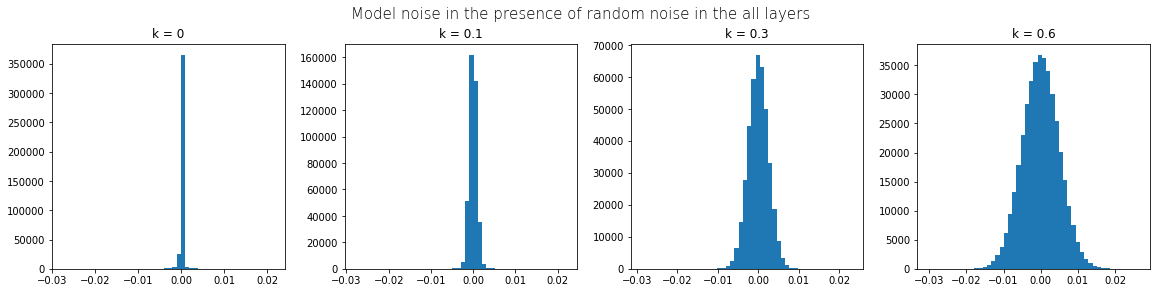

In [67]:
noiseCoefs = [0, 0.1, 0.3, 0.6]
f, axarr = plt.subplots(1, numplots, figsize=(16,4), constrained_layout=True)
f.suptitle('Model noise in the presence of random noise in the all layers', fontsize=15, fontweight=15)
for pltIdx, k in enumerate(noiseCoefs):
    realNoise = compute_realNoise(modelNoise, randNoise, k)
    realNoise1D = flatten_listArrays(realNoise)
    axarr[pltIdx].hist(realNoise1D, 50)
    axarr[pltIdx].set(title='k = {}'.format(k))

In [68]:
allRandom = []
for i in range(6176):
    randomFilter = (max_noise - min_noise) * np.random.random((3,3)) + min_noise
    allRandom.append(randomFilter.flatten())
#allRandom_tsne = TSNE(n_components=2, perplexity=40, n_iter=1200).fit_transform(allRandom)

NameError: name 'max_noise' is not defined

In [ ]:
allRandom_x, allRandom_y = allRandom_tsne.T
plt.scatter(allRandom_x, allRandom_y, s=0.3)
plt.title('Random Noise')

In [ ]:
H = np.transpose(r[2])
#f, axarr = plt.subplots(2,5, figsize=(15,7))
#for num in range(7):
#    axarr[num//5][num%5].imshow(H[num][0], cmap='gray', vmin=min_noise, vmax=max_noise)
f = plt.figure(figsize=(15,7))
ax = f.add_subplot(2,5,9)
ax1 = f.add_subplot(2,5,1)
num = 3
ax.imshow(H[num][0], cmap='gray', vmin=min_noise, vmax=max_noise)
ax1.imshow(H[num][0], cmap='gray', vmin=min_noise, vmax=max_noise)
plt.show()

In [ ]:
f, axarr = plt.subplots(2,5, figsize=(15,7))
for num in range(10):
    H = (max_noise - min_noise) * np.random.random((3,3)) + min_noise
    axarr.ravel()[num].imshow(H, cmap='gray', vmin=min_noise, vmax=max_noise)
plt.show()